In [1]:
import mne
from scipy import fftpack
from scipy.fft import fft
from scipy.signal import resample
from skimage import util
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
raw_data = mne.io.read_raw_edf('data/test2.edf', preload=True)

Extracting EDF parameters from D:\ML Projects\sleepscoring\data\test2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 43199999  =      0.000 ... 86399.998 secs...


In [4]:
raw_data.info['meas_date'].hour

10

In [5]:
df = raw_data.to_data_frame()
df.columns = ['time','activity','eeg','emg','signal_str','temp','sleep_stage']
df['sleep_stage']=df['sleep_stage']/1e6
df['sleep_stage']=df['sleep_stage'].round()
df['temp']=(df['temp']/1e7).round(4)
df.head()

stage_names ={1.0:'awake',
              2.0:'PS',
              3.0:'SWS',
              10.0:"Artifact"}

df.shape[0]/(6*60*24)

5000.0

In [6]:
sleep_stages = []
for i in range(8640):
    sleep_stages.append(df.sleep_stage[i*5000:(i+1)*5000].mean())

In [7]:
df_new = pd.DataFrame()

data_dict =  {'time':[],
              'eeg':[],
              'emg':[],
              'signal_str':[],
              'sleep_stage':[]}


for i in range(6*60*24):
    data_dict['time'].append(df.time[i*5000])
    data_dict['eeg'].append(df.eeg[i*5000:(i+1)*5000].values)
    data_dict['emg'].append(df.emg[i*5000:(i+1)*5000].values)
    data_dict['signal_str'].append(df.signal_str[i*5000:(i+1)*5000].values)
    data_dict['sleep_stage'].append(df.sleep_stage[i*5000])

In [8]:
def rectified_std(array):
    return(np.std(np.abs(array)))

def rectified_mean(array):
    return(np.mean(np.abs(array)))

In [9]:
df2 = pd.DataFrame.from_dict(data_dict)

In [10]:
df2['eeg_max'] = df2['eeg'].apply(np.max)
df2['eeg_min'] = df2['eeg'].apply(np.min)
df2['eeg_mean'] = df2['eeg'].apply(np.mean)
df2['eeg_std'] = df2['eeg'].apply(np.std)
df2['reeg_std'] = df2['eeg'].apply(rectified_std)

In [11]:
df2['emg_max'] = df2['emg'].apply(np.max)
df2['emg_min'] = df2['emg'].apply(np.min)
df2['emg_mean'] = df2['emg'].apply(np.mean)
df2['emg_std'] = df2['emg'].apply(np.std)
df2['remg_std'] = df2['emg'].apply(rectified_std)

In [12]:
df.sleep_stage.value_counts()

1.0     20920000
3.0     19255000
2.0      2560000
10.0      465000
Name: sleep_stage, dtype: int64

In [13]:
df2.eeg[0].shape

(5000,)

In [14]:
import tensorflow as tf
from tensorflow import keras


In [15]:
model = tf.keras.Sequential()
model.add(keras.layers.Conv1D(64,3, input_shape=(5000,1)))
model.add(keras.layers.MaxPool1D(pool_size=3, padding='valid'))
model.add(keras.layers.Conv1D(64,5))
model.add(keras.layers.MaxPool1D(pool_size=5, padding='valid'))
model.add(keras.layers.Conv1D(64,7))
model.add(keras.layers.MaxPool1D(pool_size=7, padding='valid'))
#model.add(keras.layers.Conv1D(64,3))
#model.add(keras.layers.MaxPool1D(pool_size=3, padding='valid'))
#model.add(keras.layers.Conv1D(64,3))
#model.add(keras.layers.MaxPool1D(pool_size=3, padding='valid'))
#model.add(keras.layers.Conv1D(64,3))
#model.add(keras.layers.MaxPool1D(pool_size=3, padding='valid'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(4))         

In [16]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

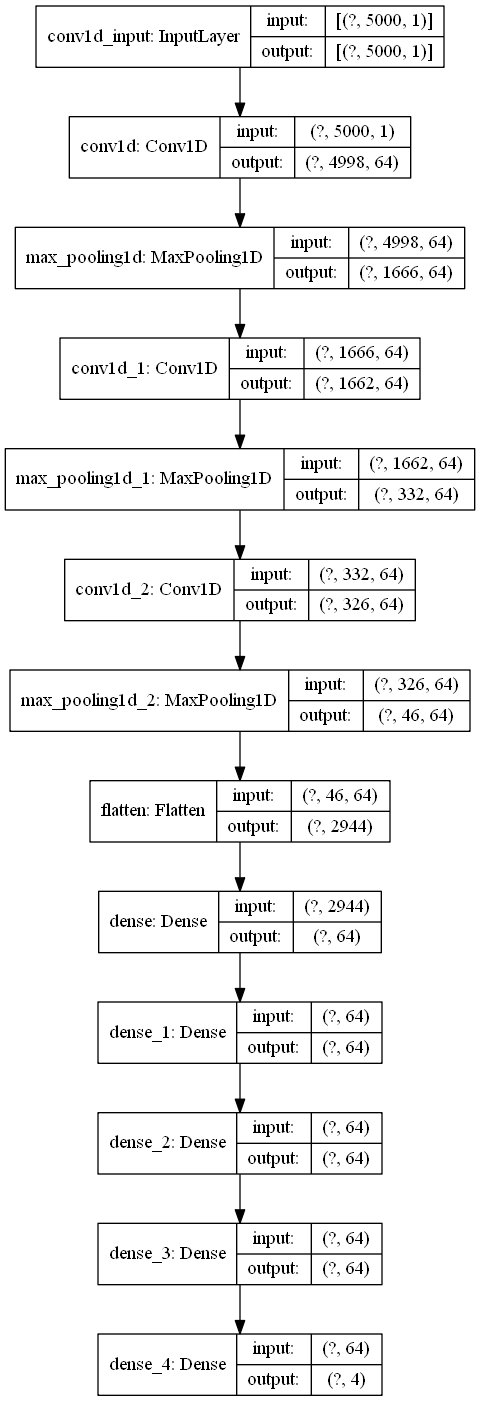

In [17]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [18]:
eeg_data = df2['eeg'].values
emg_data = df2['emg'].values


In [19]:
eeg_data = np.stack(eeg_data)
emg_data = np.stack(emg_data)
eeg_data = eeg_data.reshape(8640,5000,1)
emg_data = eeg_data.reshape(8640,5000,1)


In [20]:
train = np.concatenate([eeg_data, emg_data], axis=2)
train.shape

(8640, 5000, 2)

In [21]:
df2['awake']=df2.sleep_stage

In [22]:
df2['awake'][df2['awake']!=1]=0

C:\Users\nworl\anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [23]:
df2['PS']=df2.sleep_stage
df2['PS'][df2['PS']!=2]=0
df2['SWS']=df2.sleep_stage
df2['SWS'][df2['SWS']!=3]=0
df2['art']=df2.sleep_stage
df2['art'][df2['art']!=10]=0
df2.head()

C:\Users\nworl\anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\nworl\anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\nworl\anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,time,eeg,emg,signal_str,sleep_stage,eeg_max,eeg_min,eeg_mean,eeg_std,reeg_std,emg_max,emg_min,emg_mean,emg_std,remg_std,awake,PS,SWS,art
0,0,"[-81.94219794305246, -73.09183019501327, -65.0...","[-3.5096285897396773, -6.561479537339396, -3.9...","[34999847.40745262, 35001829.06457086, 3500382...",3.0,312.509537,-244.911039,-0.917081,61.102474,39.760782,32.044435,-29.908139,0.289377,7.608577,4.663815,0.0,0.0,3.0,0.0
1,10000,"[88.65627002777184, 81.02664265877254, 69.4296...","[11.749626148258919, 6.40888698995941, 1.37333...","[34999847.40745261, 35001522.62981798, 3500319...",3.0,353.556932,-177.159948,0.469924,59.819381,36.771851,31.586657,-25.635548,0.181982,7.415046,4.498966,0.0,0.0,3.0,0.0
2,20000,"[45.31998657185583, 46.388134403515735, 44.557...","[-5.493331705679495, -3.357036042359691, -3.35...","[34999847.40745263, 34999942.272665404, 350000...",3.0,249.488815,-258.186590,-0.268838,60.604688,38.548378,30.060732,-26.093326,0.142125,7.118925,4.415626,0.0,0.0,3.0,0.0
3,30000,"[15.86962492751854, -10.071108127079073, -40.2...","[-3.967406231879635, 3.662221137119663, 6.8666...","[34998016.29688405, 34997360.18338733, 3499669...",3.0,281.838435,-236.518448,-0.605731,65.837213,40.287144,29.145177,-24.719993,0.246803,6.920476,4.268392,0.0,0.0,3.0,0.0
4,40000,"[-96.28589739677115, -110.32441175572986, -119...","[-2.1362956633198036, -0.3051850947599719, -0....","[34999847.40745262, 34997565.92489864, 3499514...",3.0,270.851772,-160.374767,0.814844,62.723396,39.363107,36.164434,-25.330363,0.368633,6.959197,4.244282,0.0,0.0,3.0,0.0


In [24]:
df2['PS'][df2['PS']!=0]=1.0
df2['SWS'][df2['SWS']!=0]=1.0
df2['art'][df2['art']!=0]=1.0

C:\Users\nworl\anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\nworl\anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\nworl\anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from

In [25]:
sleep = df2[['awake','PS','SWS','art']].values
sleep.shape

(8640, 4)

In [26]:
sleep = sleep.reshape(8640,4,1)

In [27]:
sleep_stage = df2.sleep_stage.values
sleep_stage = sleep_stage.reshape(8640,1)
sleep_stage[sleep_stage==10.0]=4.0

In [28]:
sleep[0]

array([[0.],
       [0.],
       [1.],
       [0.]])

In [29]:
print(eeg_data.shape)
sleep = sleep.argmax(axis=1)

(8640, 5000, 1)


In [30]:
sleep.shape

(8640, 1)

In [31]:
sleep_stage = df2.sleep_stage.values

In [183]:
history = model.fit(eeg_data, sleep.argmax(axis=1), epochs=30)

Epoch 1/30
270/270 [==============================] - 2s 8ms/step - loss: 0.0670 - accuracy: 0.9797
Epoch 2/30
270/270 [==============================] - 2s 8ms/step - loss: 0.0441 - accuracy: 0.9863
Epoch 3/30
270/270 [==============================] - 2s 7ms/step - loss: 0.0736 - accuracy: 0.9797
Epoch 4/30
270/270 [==============================] - 2s 8ms/step - loss: 0.0346 - accuracy: 0.9895
Epoch 5/30
270/270 [==============================] - 2s 8ms/step - loss: 0.0557 - accuracy: 0.9866
Epoch 6/30
270/270 [==============================] - 2s 8ms/step - loss: 0.0304 - accuracy: 0.9909
Epoch 7/30
270/270 [==============================] - 2s 8ms/step - loss: 0.0433 - accuracy: 0.9869
Epoch 8/30
270/270 [==============================] - 2s 8ms/step - loss: 0.0108 - accuracy: 0.9957
Epoch 9/30
270/270 [==============================] - 2s 8ms/step - loss: 0.0482 - accuracy: 0.9848
Epoch 10/30
270/270 [==============================] - 2s 8ms/step - loss: 0.0283 - accuracy: 0.9934

In [176]:
loss = history.history['loss']
accuracy = history.history['accuracy']

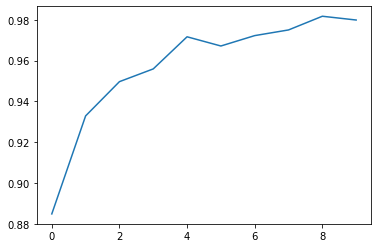

In [177]:
#plt.plot(range(len(loss)), loss)
plt.plot(range(len(loss)), accuracy)

In [184]:
x = model.predict(eeg_data)

In [185]:
predictions = x.argmax(axis=1)

In [186]:
labels = sleep.argmax(axis=1)

In [86]:
from sklearn.metrics import confusion_matrix

In [187]:
confusion_matrix(labels, predictions)

array([[4184,    0,    0,    0],
       [   0,  512,    0,    0],
       [   0,    0, 3851,    0],
       [   0,    0,    0,   93]], dtype=int64)

In [171]:
sleep.shape

(8640, 4)

In [2]:
5e-3

0.005